<h1> Cleavage Site and TAP Prediction </h1>


This tutorial illustrates the use of epytope to predict the steps of the HLA-I antigen processing pathway including proteasomal cleavage and TAP transport. epytope offers a long list of prediction methods and was  designed in such a way that extending epytope with your favorite method is easy.

This tutorial will entail:
- Simple cleavage site/fragment prediction from a list of peptide sequences and protein sequences
- Simple TAP prediction methods
- Consensus prediction of proteasomal cleavage, TAP, and HLA binding to model the complete antigen processing pathway


In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from epytope.Core import Protein, Peptide, Allele
from epytope.Core import generate_peptides_from_proteins
from epytope.IO import read_fasta
from epytope.CleavagePrediction import CleavageSitePredictorFactory, CleavageFragmentPredictorFactory
from epytope.TAPPrediction import TAPPredictorFactory

<h2> Chapter 1: Cleavage Prediction </h2>
<br/>
epytope offers a comprehensive list of state-of-the art proteasomal cleavage prediction methods. Usually one distinguishes cleavage methods into cleavage site and cleavage fragment prediction. Cleavage site prediction methods predict each possible cleavage site within a given amino acid sequence, whereas cleavage fragment prediction methods predict the likelihood of a peptide fragment of being a product of proteasomal cleavage. Additionally, the source of the training data are often also quite different. The majority of prediction tools was train on in vitro data of up to three fully analyzed proteins and distinguish between constitutive and immunoproteasomal cleavage. Some prediction methods use natural HLA ligands as training data as they are products of antigen processing pathway and therefore also of cleavage events.
<br/><br/>
But all methods start with reading in protein sequences. epytope offers several ways of defining Proteins. We can either directly initialize a `epytope.Core.Protein` object by specifying a amino acid sequence and optionally a progenitor gene and transcript id, as well as the progenitor `epytope.Core.Transcript` object, or we can directly read in proteins from FASTA files by using `epytope.IO.read_fasta`.  

In [2]:
protein = Protein("AAAAAAAAAAA", gene_id="Dummy", transcript_id="Dummy")
proteins = read_fasta("./data/proteins.fasta", id_position=3, in_type=Protein)
protein

PROTEIN: AAAAAAAAAAA (aa-seq)
		  Dummy (orig transcript)
		 VARIANTS:

Once we have a protein sequence to work with, we can specify the cleavage site prediction method of our choice. epytope offers one entry point for each type of prediction methods via so called factories. For cleavage site prediction it is `CleavageSitePredictorFactory`. To get an overview which prediction methods are currently implemented, we can use `CleavageSitePredictorFactory` as follows:

In [3]:
for name,version in CleavageSitePredictorFactory.available_methods().items():
    print(name, ",".join(version))

pcm 1.0
proteasmm_c 1.0
proteasmm_i 1.0
netchop 3.1


Lets select `PCM` for example and make predictions:

In [4]:
pcm = CleavageSitePredictorFactory("PCM")
site_result = pcm.predict(proteins)
site_result.head()

Seq   pcm
ID          Pos          
NP_852610.1 0     M  0.00
            1     K  0.00
            2     M  0.00
            3     R  0.60
            4     F -0.66

To specify a particular version of a prediction method, we can use the flag `version=""` when calling the PredictorFactories. If we do not specify any version, epytope will initialize the most recent version that is supported.

In [5]:
pcm = CleavageSitePredictorFactory("PCM", version="1.0")
site_result = pcm.predict(proteins)
site_result.head()

Seq   pcm
ID          Pos          
NP_852610.1 0     M  0.00
            1     K  0.00
            2     M  0.00
            3     R  0.60
            4     F -0.66

External tools like `NetChop` offer two additional flags when calling `.predict()`, `command="/path/to/binary"` and `options="command options"`. `command=""` specifies the path to an alternative binary that should be used instead of the one which is globally registered. With options you can specify additional commands that will directly be passed to the command line call without any sanity checks.

For CleavageFragment prediction we first have to generate peptides from protein sequences with `epytope.Core.generate_peptides_from_proteins`. epytope currently supports only one CleavageFragment prediction methods proposed by Ginodi et al. <a href="http://bioinformatics.oxfordjournals.org/content/24/4/477.long">(Ginodi, et al.(2008) Bioinformatics 24(4))</a>, which supports only 11mers (9mer epitopes and two flaking amino acids).

In [6]:
pep = generate_peptides_from_proteins(proteins, 11)
CleavageFragmentPredictorFactory("Ginodi").predict(pep).head()

,ginodi
"(A, A, V, D, P, A, D, R, C)",-18.891867
"(A, D, R, C, K, E, V, Q, Q)",-14.992024
"(A, V, D, P, A, D, R, C, K)",-14.755080
"(C, G, K, A, A, V, D, P, A)",-17.551360
"(C, K, E, V, Q, Q, I, R, D)",-17.682320


The result object is based on pandas' `DataFrame`, thus all possibilities of manipulating the results pandas offers are possible, including rudimentary plotting capabilities.

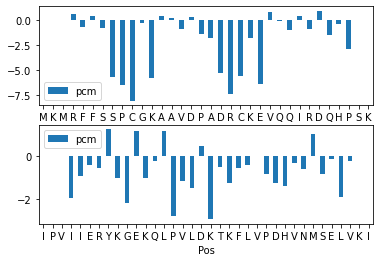

In [7]:
import matplotlib.pyplot as plt

f, a = plt.subplots(len(site_result.index.levels[0]),1)

for i,r in enumerate(site_result.index.levels[0]):
    site_result.xs(r).plot(kind='bar', ax=a[i]).set_xticklabels(site_result.loc[(r,slice(None)),"Seq"], rotation=0)


We also can combine several prediction results of the same type via `CleavageSitePredictionResults.merge_results` (Note this function returns a merge Result DataFrame):

In [8]:
import pandas as pd
import numpy

site_result2 = CleavageSitePredictorFactory("proteasmm_c").predict(proteins)
merged_result = site_result.merge_results([site_result2])
merged_result.head(7)

Seq   pcm  proteasmm_c
ID          Pos                       
NP_852610.1 0     M  0.00     0.000000
            1     K  0.00     0.000000
            2     M  0.00     0.000000
            3     R  0.60     0.000000
            4     F -0.66     0.000000
            5     F  0.41     0.967189
            6     S -0.78     0.848493

We can also filter the results based on multiple expressions with `CleavageSitePredictionResults.filter_result`.

In [9]:
comp = lambda x,y: x > y
expressions=[("pcm",comp,0)]

merged_result.filter_result(expressions)

Seq   pcm  proteasmm_c
ID              Pos                       
NP_852610.1     3     R  0.60     0.000000
                5     F  0.41     0.967189
                12    A  0.43     1.071828
                13    A  0.27     1.186948
                15    D  0.29     1.160524
                23    V  0.86     0.988586
                26    I  0.42     1.094651
                28    D  0.94     1.130923
NP_852610_part2 7     Y  1.26     1.093200
                10    E  1.19     1.029347
                13    L  1.18     1.123535
                17    D  0.51     1.173126
                29    M  1.07     1.064119

<h2> Chapter 2: TAP prediction </h2>

epytope offers only limited prediction methods for TAP prediction, due to lack of publicly available methods.

In [10]:
for name,version in TAPPredictorFactory.available_methods().items():
    print(name, ",".join(version))

doytchinova 1.0
smmtap 1.0


For TAP prediction, we first have to generate peptides. Lets take the proteins we already imported and generate 9mers, as these two methods only support 9mer peptides.

In [11]:
pep = list(generate_peptides_from_proteins(proteins,9))

tap_result = TAPPredictorFactory("smmtap").predict(pep[:15])
tap_result.head()

,smmtap
"(A, A, V, D, P, A, D, R, C)",-2.65
"(A, V, D, P, A, D, R, C, K)",-0.72
"(C, G, K, A, A, V, D, P, A)",3.05
"(F, F, S, S, P, C, G, K, A)",2.37
"(F, S, S, P, C, G, K, A, A)",1.96


Again we can do all rudimentary operations on the result object as with the cleavage result objects, including merging and filtering.

In [12]:
tap_result2 = TAPPredictorFactory("Doytchinova").predict(pep[:15])
tap_result.merge_results(tap_result2).head()

,smmtap,doytchinova
"(A, A, V, D, P, A, D, R, C)",-2.65,1.186
"(A, V, D, P, A, D, R, C, K)",-0.72,0.179
"(C, G, K, A, A, V, D, P, A)",3.05,-2.070
"(F, F, S, S, P, C, G, K, A)",2.37,-1.544
"(F, S, S, P, C, G, K, A, A)",1.96,-0.472


In [13]:
from operator import ge

tap_result.filter_result([("smmtap",ge, -30)])

,smmtap
"(A, A, V, D, P, A, D, R, C)",-2.65
"(A, V, D, P, A, D, R, C, K)",-0.72
"(C, G, K, A, A, V, D, P, A)",3.05
"(F, F, S, S, P, C, G, K, A)",2.37
"(F, S, S, P, C, G, K, A, A)",1.96
"(G, K, A, A, V, D, P, A, D)",1.69
"(K, A, A, V, D, P, A, D, R)",-1.79
"(K, M, R, F, F, S, S, P, C)",-1.46
"(M, K, M, R, F, F, S, S, P)",-1.55
"(M, R, F, F, S, S, P, C, G)",-2.20


<h2> Chapter 3: Consensus prediction for natural ligand prediction </h2>
<br/>
Proteasomal cleavage, TAP prediction, as well as HLA binding prediction have been combined to increase the specificity of predicting natural processed HLA ligands. One example is `WAPP` <a href="http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2279325/">(Dönnes, et al.(2005). Protein Science 14(8))</a>, which uses proteasomal cleavage and TAP prediction methods to filter for possibly processed peptides.

The same approach can be implemented with epytope. We start again with the two protein sequences and exemplify the workflows for CleavageFragmentPrediction and CleavageSitePrediction methods.


<h4> Antigen processing prediction with CleavageFragment prediction </h4>
<br/>
We will use `PSSMGinodi`, `SVMTAP`, and `UniTope` for prediction for HLA-A*02:01. For `PSSMGionid` and `SVMTAP` we use a threshold of -15 and -30 respectively.


In [14]:
from operator import ge
from epytope.Core import Allele
from epytope.EpitopePrediction import EpitopePredictorFactory

allele = Allele("HLA-A*02:01")

pep = list(generate_peptides_from_proteins(proteins,11))
print("Number of peptides: ", len(pep))

#cleavage prediction and filtering
df_cl = CleavageFragmentPredictorFactory("Ginodi").predict(pep).filter_result(("ginodi",ge,-15))
print("Number of peptides after proteasomal cleavage: ", len(df_cl))

#tap prediction and filtering
df_tap = TAPPredictorFactory("smmtap").predict(df_cl.index).filter_result(("smmtap",ge,-30))
print("Number of peptides after TAP transport: ", len(df_tap))

#epitope prediction and filtering
#df_epi = EpitopePredictorFactory("UniTope").predict(df_tap.index,alleles=allele)
#df_epi

Number of peptides:  50
Number of peptides after proteasomal cleavage:  31
Number of peptides after TAP transport:  31


Based on this analysis, there are no natural ligands predicted for the two test proteins.

<h4> Antigen processing prediction with CleavageSite prediction </h4>
<br/>
We will use `PCM`, `SVMTAP`, and `SVMHC` for prediction for HLA-A*02:01 like in the original work of WAPP. For `PCM` and `SVMTAP` we use a threshold of −4.8 and −27 respectively.


In [15]:
from operator import ge
from epytope.Core import Allele,Protein
from epytope.EpitopePrediction import EpitopePredictorFactory

allele = Allele("HLA-A*02:01")



#cleavage prediction and filtering
df_cl = CleavageSitePredictorFactory("PCM").predict(proteins).filter_result(("pcm",ge,-4.8))

print("Number of peptides after proteasomal cleavage: ", len(df_cl))

#since we only predicted possible cleavage site, we now have to generate all possible peptides
#peptides
pep_dic = {}
for p in proteins:
    for i in df_cl.loc[(p.transcript_id,slice(None)),:].index.codes[1]:
        if i-8>=0:
            seq = str(p[i-8:i+1])
            pep_dic.setdefault(seq, []).append(p)
peps = [Peptide(seq, protein_pos={pp:[0] for pp in p}) for seq, p in pep_dic.items()]


#tap prediction and filtering
df_tap = TAPPredictorFactory("smmtap").predict(peps).filter_result(("smmtap",ge,-27))
print("Number of peptides after TAP transport: ", len(df_tap))


#epitope prediction and filtering
df_epi = EpitopePredictorFactory("smm").predict(df_tap.index,alleles=allele).filter_result(("smm",ge,-1.0))
df_epi

Number of peptides after proteasomal cleavage:  62
Number of peptides after TAP transport:  47


,,HLA-A*02:01
Seq,Method,
"(A, D, R, C, K, E, V, Q, Q)",smm,1.718344e+07
"(A, V, D, P, A, D, R, C, K)",smm,3.444372e+05
"(C, G, K, A, A, V, D, P, A)",smm,1.644788e+05
"(C, K, E, V, Q, Q, I, R, D)",smm,1.306502e+07
"(D, H, V, N, M, S, E, L, V)",smm,1.625961e+05
"(D, K, T, K, F, L, V, P, D)",smm,2.455331e+06
"(D, P, A, D, R, C, K, E, V)",smm,8.338924e+04
"(D, R, C, K, E, V, Q, Q, I)",smm,1.799327e+06
"(E, K, Q, L, P, V, L, D, K)",smm,5.421382e+07


Here as well, we did not predict any natural ligands.